<h1 align="center"> CS3244 The Art of Movie Posters: A Machine Learning Approach </h1>

Today, our world is saturated with films and movie posters. Platforms like Netflix and Hulu place great importance upon visually stunning posters. With so many works grasping at our attention, designing eye-catching posters have become an integral element in achieving success for movie producers. For us unwitting viewers, seeing a movie poster should immediately register its genre in our minds.

Our project aims to model how a viewer would perceive movie posters using machine learning. We compared and combined several traditional methods with today’s more cutting edge algorithms to produce critical insights for graphic designers to design more effective posters.

This notebook is split into 4 different sections:
* Data Exploration
* Data Pre-processing
* Data Visualization
* Feature Extraction
* Classification Algorithms and Performance Measurements

### Data Exploration

The dataset that we are using is borrowed from Kaggle at: https://tinyurl.com/y6f3aeuq \
In this section, we will be doing some exploration of the data and picking out what's useful for us.

In [2]:
import csv
import urllib
import os
import numpy as np
import pandas as pd

from skimage import io
from matplotlib import pyplot as plt
import cv2

In [85]:
rawData = pd.read_csv("MovieGenre.csv", encoding='unicode_escape')
cols = rawData.columns
unwantedCols = ['Imdb Link', 'Poster']
rawData = rawData.drop(columns=unwantedCols)
rawData = rawData.dropna()
rawData.isnull().any()

uniqueGenres = set()
genres = rawData["Genre"].str.split("|", expand=True)
for col in genres:
    for genre in genres[col]:
        if genre is None:
            continue
        uniqueGenres.add(genre)

In our exploration, we cleaned up the data by removing nulls and also extracted some useful information for pre-processing. We have also downloaded all sample posters for us to use downstream.

### Data Pre-processing

We first create a list of outcomes for the precictions by converting the genres to columns. We then save it for use in the next part.

In [115]:
import copy

for genre in uniqueGenres:
    rawData[genre] = 0
newData = copy.deepcopy(rawData)
newData["Genre"] = rawData["Genre"].str.split("|", expand=False)
for idx, genres in enumerate(newData["Genre"]):
    for genre in genres:
        newData[genre].iloc[idx] = 1
        
# newData.head()
newData.to_csv('processed1.csv')

C:\Users\zhuan\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Data Visualization

Populating the interactive namespace from numpy and matplotlib


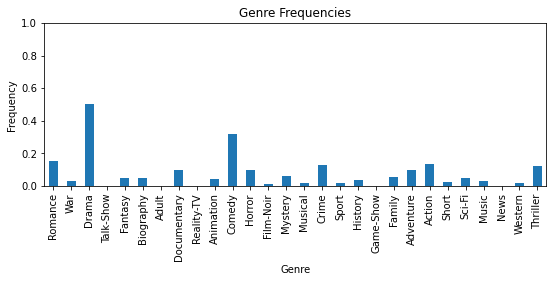

In [2]:
%matplotlib inline
%pylab inline

data = pd.read_csv('processed1.csv')
del data['Unnamed: 0']

# data.head()
genres = data.iloc[:,4:]
# genres.head()
frequency = dict()
for val in genres.columns.values:
    frequency[val] = sum(genres[val])

pylab.rcParams['figure.figsize'] = (9, 3)
genre_frequencies = {k : ((float(v))/((data.shape[0]))) for k,v in frequency.items()}
genre_frequencies_df = pd.DataFrame.from_dict(genre_frequencies,orient = "index")
genre_frequencies_df.plot(kind='bar', title='Genre Frequencies', ylim=(0.0,1.0), legend = False)
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()
    

Many movies have more than 1 genre, let's put that into perspective.

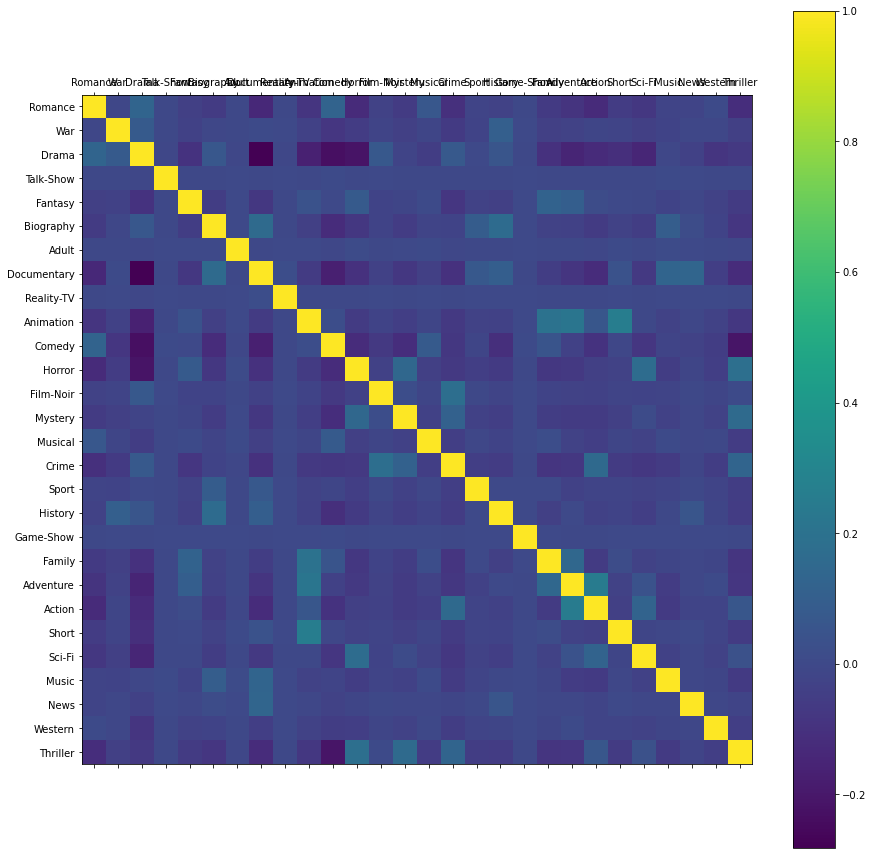

In [3]:
genre_for_correlation = genres
genre_correlation = genre_for_correlation.corr()
pylab.rcParams['figure.figsize'] = (15, 15)
plt.matshow(genre_correlation)
plt.xticks(range(len(genre_for_correlation.columns)), genre_for_correlation.columns)
plt.yticks(range(len(genre_for_correlation.columns)), genre_for_correlation.columns)
plt.colorbar()
plt.show()

### Feature Extraction

As we only have movie posters, we would want to do some feature extractions of the images to get some training features. Let's try extracting the following features from each poster:
* Faces and Emotions
* Dominant HSV

#### Extract Faces and Emotions

In [4]:
import face_recognition
import csv
import cv2
import time
import progressbar
from skimage import io
from keras.models import load_model
emotion_dict= {'Angry': 0, 'Sad': 5, 'Neutral': 4, 'Disgust': 1, 'Surprise': 6, 'Fear': 2, 'Happy': 3}
label_map = dict((v,k) for k,v in emotion_dict.items())

results = dict()
poster_ids = list()

classifier = load_model('emotions_model.hdf5')

In [5]:
data = pd.read_csv('processed1.csv')
del data['Unnamed: 0']
noImage = list()

for emotion in emotion_dict:
    data[emotion] = 0
    
# for idx, pid in progressbar.progressbar(enumerate(data["imdbId"])):
for pid in progressbar.progressbar(data["imdbId"]):
    try:
        filepath = f'./SamplePosters/{pid}.jpg'
        image = io.imread(filepath)
    except:
        noImage.append(idx)
        continue
    face_locations = face_recognition.face_locations(image)
    if len(face_locations) == 0:
        continue
    for face_location in face_locations:
        top, right, bottom, left = face_location
        face_image = image[top:bottom, left:right]
        face_image = cv2.resize(face_image, (48,48))
        try:
            face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
        except:
            None
        face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])
        pred = np.argmax(classifier.predict(face_image))
#         data[label_map[pred]].iloc[idx] += 1        
        data[label_map[pred]].loc[pid] += 1

/ |#                                                  | 0 Elapsed Time: 0:00:00C:\Users\zhuan\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
| |            #                                  | 39916 Elapsed Time: 0:22:25


Now that we have extracted faces and emotions from all the posters, we do some cleaning up in the next cell to remove rows that has got no images.

In [12]:
data2 = data.drop(noImage)
# data2.head()
data2.to_csv('processed2.csv')

#### Extract dominant HSV

Before extracting the dominant HSV, we can speed up the process by downsampling every image so that we can greatly reduce running time.

In [15]:
resized_posters = list()
standard_dimension = (100, 100)

for pid in progressbar.progressbar(data2["imdbId"]):
    filepath = f'./SamplePosters/{pid}.jpg'
    save_path = f'./ProcessedPosters/{pid}.jpg'
    image = io.imread(filepath)
    resized_image = cv2.resize(image, standard_dimension)
    io.imsave(save_path, resized_image)

100% (37357 of 37357) |##################| Elapsed Time: 0:01:42 Time:  0:01:42


resize complete


Next, we add in 3 more features into our dataframe and start doing some clustering to extract the dominant colors of each poster. We user clustering instead of averaging as averaging usually does not give a color close to the actual dominant color.

In [4]:
from sklearn.cluster import KMeans
from collections import Counter
import progressbar
dominant_hsv = dict()
data2 = pd.read_csv('processed2.csv')
data2['h'] = data2['s'] = data2['v'] = 0

def get_dominant_color(image, k=4):    
    try:
        image = image.reshape((image.shape[0] * image.shape[1], 3))

        clt = KMeans(n_clusters = k)
        labels = clt.fit_predict(image)

        label_counts = Counter(labels)

        dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]

        return list(dominant_color)
    
    except:
        return False

for pid in progressbar.progressbar(data2["imdbId"]):
    filepath = f'./SamplePosters/{pid}.jpg'
    image = io.imread(filepath)
    dom = get_dominant_color(image)
    if dom == False:
        continue
    data2['h'].loc[pid] = dom[0]
    data2['s'].loc[pid] = dom[1]
    data2['v'].loc[pid] = dom[2]

100% (37357 of 37357) |##################| Elapsed Time: 3:46:29 Time:  3:46:29


In [19]:
# data2.to_csv('processed_done.csv')
data2['h'].to_csv('h.csv')
data2['s'].to_csv('s.csv')
data2['v'].to_csv('v.csv')

In [23]:
data3 = pd.read_csv('processed_done.csv')
h = pd.read_csv('h.csv')
s = pd.read_csv('s.csv')
v = pd.read_csv('v.csv')
df4 = pd.merge(data3, h, on='imdbId')
df5 = pd.merge(df4, s, on='imdbId')
df6 = pd.merge(df5, v, on='imdbId')
df6.to_csv('final.csv')

Now that we have extracted all the features we could, we can then start training some models with these data.

### Classification Algorithms and Measurements

We will first need to do a little data-wrangling to split the data into outcomes and features.

In [29]:
df6 = pd.read_csv('final.csv')
del df6['Unnamed: 0']
df6.head()

,imdbId,Title,IMDB Score,Genre,Romance,War,Drama,Talk-Show,Fantasy,Biography,...,Angry,Sad,Neutral,Disgust,Surprise,Fear,Happy,h,s,v
0,114709,Toy Story (1995),8.3,"['Animation', 'Adventure', 'Comedy']",0,0,0,0,0,0,...,0,0,0,0,0,0,0,68.428485,43.808788,46.308485
1,113497,Jumanji (1995),6.9,"['Action', 'Adventure', 'Family']",0,0,0,0,0,0,...,0,0,0,0,0,0,0,14.509293,12.280497,11.926309
2,113228,Grumpier Old Men (1995),6.6,"['Comedy', 'Romance']",1,0,0,0,0,0,...,0,0,0,0,0,0,0,29.986902,13.568052,15.625285
3,114885,Waiting to Exhale (1995),5.7,"['Comedy', 'Drama', 'Romance']",1,0,1,0,0,0,...,0,0,0,0,0,0,0,245.876800,243.970933,226.582400
4,113041,Father of the Bride Part II (1995),5.9,"['Comedy', 'Family', 'Romance']",1,0,0,0,0,0,...,0,0,0,0,0,1,0,19.597722,10.616007,10.013489


In [33]:
outcomes = df6.loc[:,'Romance':'Thriller']
outcomes = pd.concat([df6[['imdbId']], outcomes], axis=1)
outcomes = outcomes.set_index('imdbId')
outcomes.head()

,Romance,War,Drama,Talk-Show,Fantasy,Biography,Adult,Documentary,Reality-TV,Animation,...,Game-Show,Family,Adventure,Action,Short,Sci-Fi,Music,News,Western,Thriller
imdbId,,,,,,,,,,,,,,,,,,,,,
114709,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
113497,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
113228,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114885,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113041,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import copy

vectorizer = TfidfVectorizer(max_df=0.01,min_df=0.001)
values = copy.deepcopy(df6['Title'].values)
print(values)
vectorized = vectorizer.fit_transform(values)
words = vectorizer.get_feature_names()
vectorized_array = vectorized.toarray()
bagofwords = pd.DataFrame(vectorized_array, columns=words)
bagofwords = bagofwords.add_prefix('word_')
bagofwords = pd.concat([df6[['imdbId']], bagofwords], axis=1)
bagofwords = bagofwords.set_index("imdbId")
print(bagofwords.shape)
bagofwords.head()

['Toy Story (1995)' 'Jumanji (1995)' 'Grumpier Old Men (1995)' ...
 'Pacific Banana (1981)' 'Werewolf in a Womens Prison (2006)'
 'Xiao zi ming da (1979)']
(35099, 330)


,word_10,word_1945,word_1946,word_1947,word_1948,word_1949,word_1950,word_1951,word_1952,word_1953,...,word_without,word_woman,word_women,word_world,word_year,word_york,word_you,word_young,word_your,word_zero
imdbId,,,,,,,,,,,,,,,,,,,,,
114709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
imdbId = df6.loc[:,'imdbId']
imdbId.head()
features = df6.loc[:,'Angry':'v']
concat = pd.concat([imdbId, features], axis=1)
features = concat.set_index("imdbId")
# features = pd.merge(features, bagofwords, on='imdbId')
features = pd.concat([features, bagofwords], axis=1)

cols = [c for c in features.columns if c.lower()[:4] != 'word_1']

features=features[cols]
cols = [c for c in features.columns if c.lower()[:4] != 'word_2']
features=features[cols]
features.head()
columnsInfo = features.columns

In [93]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled = pd.DataFrame(scaled_features, columns=columnsInfo, index=features.index)
scaled.head()

,Angry,Sad,Neutral,Disgust,Surprise,Fear,Happy,h,s,v,...,word_without,word_woman,word_women,word_world,word_year,word_york,word_you,word_young,word_your,word_zero
imdbId,,,,,,,,,,,,,,,,,,,,,
114709,-0.318526,-0.03164,-0.014124,0.0,-0.272244,-0.385408,-0.117128,-0.467862,-0.640763,-0.569672,...,-0.034334,-0.049038,-0.038514,-0.065166,-0.044173,-0.036579,-0.079206,-0.04218,-0.050617,-0.034835
113497,-0.318526,-0.03164,-0.014124,0.0,-0.272244,-0.385408,-0.117128,-1.016430,-0.966498,-0.933322,...,-0.034334,-0.049038,-0.038514,-0.065166,-0.044173,-0.036579,-0.079206,-0.04218,-0.050617,-0.034835
113228,-0.318526,-0.03164,-0.014124,0.0,-0.272244,-0.385408,-0.117128,-0.858963,-0.953196,-0.894199,...,-0.034334,-0.049038,-0.038514,-0.065166,-0.044173,-0.036579,-0.079206,-0.04218,-0.050617,-0.034835
114885,-0.318526,-0.03164,-0.014124,0.0,-0.272244,-0.385408,-0.117128,1.337481,1.427219,1.337029,...,-0.034334,-0.049038,-0.038514,-0.065166,-0.044173,-0.036579,-0.079206,-0.04218,-0.050617,-0.034835
113041,-0.318526,-0.03164,-0.014124,0.0,-0.272244,1.709918,-0.117128,-0.964661,-0.983695,-0.953553,...,-0.034334,-0.049038,-0.038514,-0.065166,-0.044173,-0.036579,-0.079206,-0.04218,-0.050617,-0.034835


In [101]:
finalInstance = scaled
finalInstance['imdbId'] = finalInstance.index

finalOutcomes = outcomes
finalOutcomes['imdbId'] = finalOutcomes.index

print(finalInstance.shape)
print(finalOutcomes.shape)

(35099, 341)
(35099, 29)


In [102]:
finalInstance.describe()

,Angry,Sad,Neutral,Disgust,Surprise,Fear,Happy,h,s,v,...,word_woman,word_women,word_world,word_year,word_york,word_you,word_young,word_your,word_zero,imdbId
count,3.509900e+04,3.509900e+04,3.509900e+04,35099.0,3.509900e+04,3.509900e+04,3.509900e+04,3.509900e+04,3.509900e+04,3.509900e+04,...,3.509900e+04,3.509900e+04,3.509900e+04,3.509900e+04,3.509900e+04,3.509900e+04,3.509900e+04,3.509900e+04,3.509900e+04,3.509900e+04
mean,1.127092e-14,2.500939e-15,-1.191368e-15,0.0,-3.919303e-15,1.197824e-14,-4.813263e-15,4.143844e-17,-7.847065e-17,-7.406759e-17,...,-4.351656e-15,-1.453470e-15,-2.320594e-15,-1.161575e-15,-4.488537e-15,-9.865214e-17,3.073829e-15,-3.244829e-15,-3.139032e-15,9.262852e+05
std,1.000014e+00,1.000014e+00,1.000014e+00,0.0,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,...,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.179008e+06
min,-3.185259e-01,-3.164021e-02,-1.412359e-02,0.0,-2.722440e-01,-3.854077e-01,-1.171284e-01,-1.162304e+00,-1.091605e+00,-1.057651e+00,...,-4.903764e-02,-3.851419e-02,-6.516600e-02,-4.417284e-02,-3.657917e-02,-7.920592e-02,-4.217960e-02,-5.061690e-02,-3.483500e-02,3.736500e+04
25%,-3.185259e-01,-3.164021e-02,-1.412359e-02,0.0,-2.722440e-01,-3.854077e-01,-1.171284e-01,-9.445682e-01,-9.120655e-01,-8.760991e-01,...,-4.903764e-02,-3.851419e-02,-6.516600e-02,-4.417284e-02,-3.657917e-02,-7.920592e-02,-4.217960e-02,-5.061690e-02,-3.483500e-02,9.439400e+04
50%,-3.185259e-01,-3.164021e-02,-1.412359e-02,0.0,-2.722440e-01,-3.854077e-01,-1.171284e-01,-4.981098e-01,-5.239437e-01,-5.446908e-01,...,-4.903764e-02,-3.851419e-02,-6.516600e-02,-4.417284e-02,-3.657917e-02,-7.920592e-02,-4.217960e-02,-5.061690e-02,-3.483500e-02,3.313380e+05
75%,-3.185259e-01,-3.164021e-02,-1.412359e-02,0.0,-2.722440e-01,-3.854077e-01,-1.171284e-01,1.160137e+00,1.187735e+00,1.184514e+00,...,-4.903764e-02,-3.851419e-02,-6.516600e-02,-4.417284e-02,-3.657917e-02,-7.920592e-02,-4.217960e-02,-5.061690e-02,-3.483500e-02,1.477092e+06
max,1.740732e+01,5.999753e+01,7.080355e+01,0.0,1.538223e+01,1.009122e+01,4.915961e+01,1.427631e+00,1.538489e+00,1.634977e+00,...,2.612406e+01,3.272483e+01,1.964935e+01,2.930506e+01,4.084665e+01,1.792826e+01,2.809745e+01,2.758682e+01,3.203306e+01,6.098922e+06


In [103]:
finalOutcomes.describe()

,Romance,War,Drama,Talk-Show,Fantasy,Biography,Adult,Documentary,Reality-TV,Animation,...,Family,Adventure,Action,Short,Sci-Fi,Music,News,Western,Thriller,imdbId
count,35099.000000,35099.000000,35099.000000,35099.000000,35099.000000,35099.000000,35099.000000,35099.000000,35099.000000,35099.000000,...,35099.000000,35099.000000,35099.000000,35099.000000,35099.000000,35099.000000,35099.000000,35099.000000,35099.000000,3.509900e+04
mean,0.147298,0.027095,0.502009,0.000171,0.051426,0.051568,0.000228,0.098293,0.000057,0.044218,...,0.053050,0.096584,0.139975,0.020314,0.052851,0.033021,0.002222,0.019345,0.127696,9.262852e+05
std,0.354407,0.162362,0.500003,0.013074,0.220868,0.221157,0.015096,0.297715,0.007549,0.205582,...,0.224136,0.295395,0.346967,0.141074,0.223738,0.178694,0.047089,0.137737,0.333756,1.179008e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.736500e+04
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.439400e+04
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.313380e+05
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.477092e+06
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.098922e+06


In [104]:
np.random.seed(782326)
x_train, x_test, y_train, y_test = train_test_split(finalInstance, finalOutcomes, test_size=0.3)
x_train.to_csv('x_train.csv')
y_train.to_csv('y_train.csv')
x_test.to_csv('x_test.csv')
y_test.to_csv('y_test.csv')

(24569, 341)

Now, we can finally do some training and testing of our data.

In [42]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import hamming_loss
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

x_test = pd.read_csv("x_test.csv")
x_train = pd.read_csv("x_train.csv")
y_test = pd.read_csv("y_test.csv")
y_train = pd.read_csv("y_train.csv")

This next cell is the training values for when x contains features from the title.

In [43]:
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

In [26]:
x_train_no_words = pd.read_csv("x_train.csv")
x_test_no_words = pd.read_csv("x_test.csv")
x_train_no_words = x_train_no_words.loc[:,'Angry':'v']
# x_train_no_words.head()
x_test_no_words = x_test_no_words.loc[:,'Angry':'v']
x_test_no_words.head()

,Angry,Sad,Neutral,Disgust,Surprise,Fear,Happy,h,s,v
0,-0.318526,-0.03164,-0.014124,0.0,-0.272244,-0.385408,-0.117128,1.407186,1.512608,1.571383
1,-0.318526,-0.03164,-0.014124,0.0,-0.272244,-0.385408,-0.117128,1.336567,1.436667,1.559571
2,-0.318526,-0.03164,-0.014124,0.0,-0.272244,1.709918,-0.117128,1.256662,1.341439,1.343943
3,-0.318526,-0.03164,-0.014124,0.0,2.858651,-0.385408,-0.117128,1.250334,1.376320,1.480764
4,-0.318526,-0.03164,-0.014124,0.0,-0.272244,-0.385408,-0.117128,-0.418888,-0.492336,-0.448245


### Random Forests Classifier

In [45]:
rfc_mdl = RFC(n_estimators=50, max_depth=25, class_weight ='balanced', n_jobs=-1).fit(x_train,y_train)
rf_pred = rfc_mdl.predict(x_test)
hl = hamming_loss(y_test, rf_pred)
f1 = f1_score(y_test, rf_pred, average=None)
print("Random Forest")
print("Hamming Loss of RF is " + str(hl))
print("F1 score of RF is " + str(max(f1)))

Random Forest
Hamming Loss of RF is 0.0782322615655949
F1 score of RF is 0.15907710989678203


C:\Users\zhuan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


### Naive Bayes Classifier

In [29]:
from sklearn.naive_bayes import GaussianNB
nb = OneVsRestClassifier(GaussianNB(), n_jobs=-1)
nb.fit(x_train, y_train)
nb_pred = nb.predict(x_test)
hl = hamming_loss(y_test, nb_pred)
f1 = f1_score(y_test, nb_pred, average=None)
print("Naive Bayes")
print("Hamming Loss of NB with words as features is " + str(hl))
print("F1 score of NB with words as features is " + str(max(f1)))

Naive Bayes
Hamming Loss of NB is 0.08182064848731516
F1 score of NB is 0.6159735775409098


In [30]:
from sklearn.naive_bayes import GaussianNB
nb = OneVsRestClassifier(GaussianNB(), n_jobs=-1)
nb.fit(x_train_no_words, y_train)
nb_pred = nb.predict(x_test_no_words)
hl = hamming_loss(y_test, nb_pred)
f1 = f1_score(y_test, nb_pred, average=None)
print("Naive Bayes")
print("Hamming Loss of NB without words as features is " + str(hl))
print("F1 score of NB without words as features is " + str(max(f1)))

Naive Bayes
Hamming Loss of NB is 0.7160731244064578
F1 score of NB is 0.4074133248122704


### ADABoost Classifier

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf = OneVsRestClassifier(AdaBoostClassifier(DecisionTreeClassifier(max_depth=9), n_estimators=50, algorithm="SAMME", learning_rate=0.5))
ada_clf.fit(x_train, y_train)
ada_clf_pred = ada_clf.predict(x_test)
hl = hamming_loss(y_test, ada_clf_pred)
f1 = f1_score(y_test, ada_clf_pred, average=None)
print("ada boost")
print("Hamming Loss of ada with words as features is " + str(hl))
print("F1 of ada with words as features is " + str(max(f1)))

C:\Users\zhuan\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 18 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


ada boost
Hamming Loss of ada is 0.07520010853344186
F1 of ada is 0.571245889660212


In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf = OneVsRestClassifier(AdaBoostClassifier(DecisionTreeClassifier(max_depth=9), n_estimators=50, algorithm="SAMME", learning_rate=0.5))
ada_clf.fit(x_train_no_words, y_train)
ada_clf_pred = ada_clf.predict(x_test_no_words)
hl = hamming_loss(y_test, ada_clf_pred)
f1 = f1_score(y_test, ada_clf_pred, average=None)
print("ada boost")
print("Hamming Loss of ada without words as features is " + str(hl))
print("F1 of ada without words as features is " + str(max(f1)))

C:\Users\zhuan\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 18 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


ada boost
Hamming Loss of ada without words as features is 0.0766449599782933
F1 of ada without words as features is 0.5175630085334392


### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
lr_mdl = OneVsRestClassifier(LogisticRegression(class_weight='balanced', C=100, solver='sag', max_iter = 2500), n_jobs=-1)
lr_mdl.fit(x_train, y_train)
lr_pred = lr_mdl.predict(x_test)
hl = hamming_loss(y_test, lr_pred)
print("Logistic Regression")
print("Hamming Loss of LR is " + str(hl))

Logistic Regression
Hamming Loss of LR is 0.3643060643060643


In [ ]:
pca = PCA(n_components=0.95)
pca.fit(x_train)
var90pcs = len(pca.explained_variance_ratio_[np.cumsum(pca.explained_variance_ratio_)<.95])
# reduce data using PCA
X_train_reduced = pca.transform((x_train))
X_test_reduced = pca.transform((x_test))
lr_mdl_pca = OneVsRestClassifier(LogisticRegression(class_weight='balanced', C=100, solver='sag', max_iter = 5000), n_jobs=-1)
lr_mdl_pca.fit(X_train_reduced[:,0:var90pcs], y_train)
lr_pred_pca = lr_mdl_pca.predict(X_test_reduced[:,0:var90pcs])
hl = hamming_loss(y_test, lr_pred_pca)
f1 = f1_score(y_test, lr_pred_pca, average=None)

print("Logistic Regression with words as features with PCA")
print("Hamming Loss with words as features of LR with PCA is " + str(hl))
print("F1 score with words as features of LR with PCA is " + str(max(f1)))

In [35]:
pca = PCA(n_components=0.95)
pca.fit(x_train_no_words)
var90pcs = len(pca.explained_variance_ratio_[np.cumsum(pca.explained_variance_ratio_)<.95])
# reduce data using PCA
X_train_reduced = pca.transform((x_train_no_words))
X_test_reduced = pca.transform((x_test_no_words))
lr_mdl_pca = OneVsRestClassifier(LogisticRegression(class_weight='balanced', C=100, solver='sag', max_iter = 5000), n_jobs=-1)
lr_mdl_pca.fit(X_train_reduced[:,0:var90pcs], y_train)
lr_pred_pca = lr_mdl_pca.predict(X_test_reduced[:,0:var90pcs])
hl = hamming_loss(y_test, lr_pred_pca)
f1 = f1_score(y_test, lr_pred_pca, average=None)

print("Logistic Regression without words as features with PCA")
print("Hamming Loss without words as features of LR with PCA is " + str(hl))
print("F1 score without words as features of LR with PCA is " + str(max(f1)))

Logistic Regression without words as features with PCA
Hamming Loss without words as features of LR with PCA is 0.44634717134717133
F1 score without words as features of LR with PCA is 0.49160146061554516
